<a target="_blank" href="https://colab.research.google.com/github/georgevsaliens/qubit-hardware-database/blob/main/create_db.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Generate Database from google sheets url

In [2]:
import sqlite3
import os
import pandas as pd

# Google Sheet ID (from the URL)
SHEET_ID = "158mz7xAjDFkdbqp3O21ImE8iuDVOflKmgsl9-1Y5QcE"
SHEET_NAME = "Sheet1"
csv_url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}"

df = pd.read_csv(csv_url, dtype=str).fillna("-")

# Clean DOI column
def clean_doi(doi):
    return doi.replace("https://doi.org/", "").strip()

# Drop columns that start with "Unnamed"
df = df.loc[:, ~df.columns.str.startswith("Unnamed")]

df["DOI"] = df["DOI"].apply(clean_doi)
df = df.drop_duplicates(subset=["DOI"])  # Remove duplicate DOI entries

db_path = "qubit_data.db"
if os.path.exists(db_path):
    os.remove(db_path)  # Remove existing DB to start fresh

conn = sqlite3.connect(db_path)
c = conn.cursor()

# Create main table
c.execute('''
CREATE TABLE main (
    DOI TEXT PRIMARY KEY,
    Hardware_Type TEXT,
    Year TEXT,
    Number_of_Qubits TEXT,
    Temperature_K TEXT,
    Summary TEXT,
    Notes TEXT,
    Other TEXT
)
''')

# Create tables for normalized data
normalized_tables = {
    "T1_Times": "T1 Times (ms)",
    "T2_Times": "T2 Times (ms)",
    "Single_Qubit_Fidelity": "Single Qubit gate fidelity",
    "Two_Qubit_Fidelity": "Two Qubit Gate Fidelity",
    "Measurement_Error": "Measurement Error",
    "State_Prep_Error": "State Preperation Error",
    "SPAM_Error": "SPAM Error",
    "Single_Qubit_Gate_time": "Gate Durations (single qubit) (ms)",
    "Two_Qubit_Gate_time": "Gate Durations (two qubit) (ms)"
    }

for table, col in normalized_tables.items():
    c.execute(f'''
    CREATE TABLE {table} (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        DOI TEXT,
        Value REAL,
        Uncertainty REAL,
        Notes TEXT,
        FOREIGN KEY (DOI) REFERENCES main(DOI)
    )
    ''')

# Insert data into the main table
for _, row in df.iterrows():
    c.execute('''
    INSERT INTO main (DOI, Hardware_Type, Year, Number_of_Qubits, Temperature_K, Summary, Notes, Other)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    ''', (row["DOI"].strip(), row["Hardware Type"].strip(), row["Year"].strip(), row["Number of Qubits"].strip(),
          row["Temperature (K)"].strip(), row["Summary"].strip(), row["Notes"].strip(), row["Other"].strip()))

# Function to insert parsed values into normalized tables
def insert_normalized_data(table_name, doi, entry):
    if entry == "-":  # Skip empty values
        return

    values = entry.split(";")  # Split multiple entries
    for value in values:
        value = value.strip()
        if ":" in value:  # Check if uncertainty is present
            num_part, unc_part = value.split(":")
            num_part = num_part.strip()
            unc_part = unc_part.strip()
        else:
            num_part = value
            unc_part = None

        c.execute(f'''
        INSERT INTO {table_name} (DOI, Value, Uncertainty)
        VALUES (?, ?, ?)
        ''', (doi, num_part, unc_part))


def insert_normalized_data_fixed(table_name, doi, entry):
    if entry == "-":
        return
    values = entry.split(";")
    for value in values:
        value = value.strip()
        num_part, unc_part = None, None
        if ":" in value:
            parts = value.split(":")
            num_part = parts[0].strip()
            unc_part = parts[1].strip() if len(parts) > 1 else None
        else:
            num_part = value
        try:
            num_part = float(num_part) if num_part else None
            unc_part = float(unc_part) if unc_part else None
            # print(f"Inserting into {table_name}: DOI={doi}, Value={num_part}, Uncertainty={unc_part}")
            c.execute(f'''
            INSERT INTO {table_name} (DOI, Value, Uncertainty)
            VALUES (?, ?, ?)
            ''', (doi, num_part, unc_part))
        except ValueError:
            print(f"Skipping invalid entry in {table_name}: DOI={doi}, entry={value}")

# Add before the loop
# print("DataFrame columns:", df.columns.tolist())

# Insert data
for table, col in normalized_tables.items():
    print(f"Processing table {table} with column {col}")
    for _, row in df.iterrows():
        # print(f"Row DOI={row['DOI']}, {col}={row[col]}")
        insert_normalized_data_fixed(table, row["DOI"].strip(), row[col])

conn.commit()
conn.close()

print("Database and tables created successfully.")

Processing table T1_Times with column T1 Times (ms)
Processing table T2_Times with column T2 Times (ms)
Processing table Single_Qubit_Fidelity with column Single Qubit gate fidelity
Processing table Two_Qubit_Fidelity with column Two Qubit Gate Fidelity
Processing table Measurement_Error with column Measurement Error
Processing table State_Prep_Error with column State Preperation Error
Processing table SPAM_Error with column SPAM Error
Processing table Single_Qubit_Gate_time with column Gate Durations (single qubit) (ms)
Processing table Two_Qubit_Gate_time with column Gate Durations (two qubit) (ms)
Database and tables created successfully.


## Testing data entries

In [5]:
'''
normalized_tables = {
    "T1_Times": "T1 Times (ms)",
    "T2_Times": "T2 Times (ms)",
    "Single_Qubit_Fidelity": "Single Qubit gate fidelity",
    "Two_Qubit_Fidelity": "Two Qubit Gate Fidelity",
    "Measurement_Error": "Measurement Error",
    "State_Prep_Error": "State Preperation Error",
    "SPAM_Error": "SPAM Error",
    "Single_Qubit_Gate_time": "Gate Durations (single qubit) (ms)",
    "Two_Qubit_Gate_time": "Gate Durations (two qubit) (ms)"
}
'''

# Connect to the SQLite database
db_path = "qubit_data.db"
conn = sqlite3.connect(db_path)

# Query to get T1 times
query = """
SELECT * FROM Two_Qubit_Gate_time;
"""

# Read the data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)
print(df)

    id                               DOI     Value Uncertainty Notes
0    1    10.1103/PhysRevLett.104.010503  0.000700        None  None
1    2               10.1038/nature15263  0.000350        None  None
2    3                  10.1038/nphys961  0.000050        None  None
3    4               10.1038/nature02008  0.039000        None  None
4    5    10.1103/PhysRevLett.100.200502  0.400000        None  None
5    6    10.1103/PhysRevLett.100.200502  0.010000        None  None
6    7               10.1038/nature16184  0.027400        None  None
7    8    10.1103/PhysRevLett.123.120502  0.040000        None  None
8    9            10.1126/sciadv.aao3603  0.278000        None  None
9   10        10.1103/PhysRevA.87.030301  0.420000        None  None
10  11               10.1038/nature13171  0.043000        None  None
11  12         10.1038/s41534-016-0003-1  0.000100        None  None
12  13         10.1038/s41534-016-0003-1  0.000200        None  None
13  14           10.1126/science.a

# Example Plots

### Basic examples

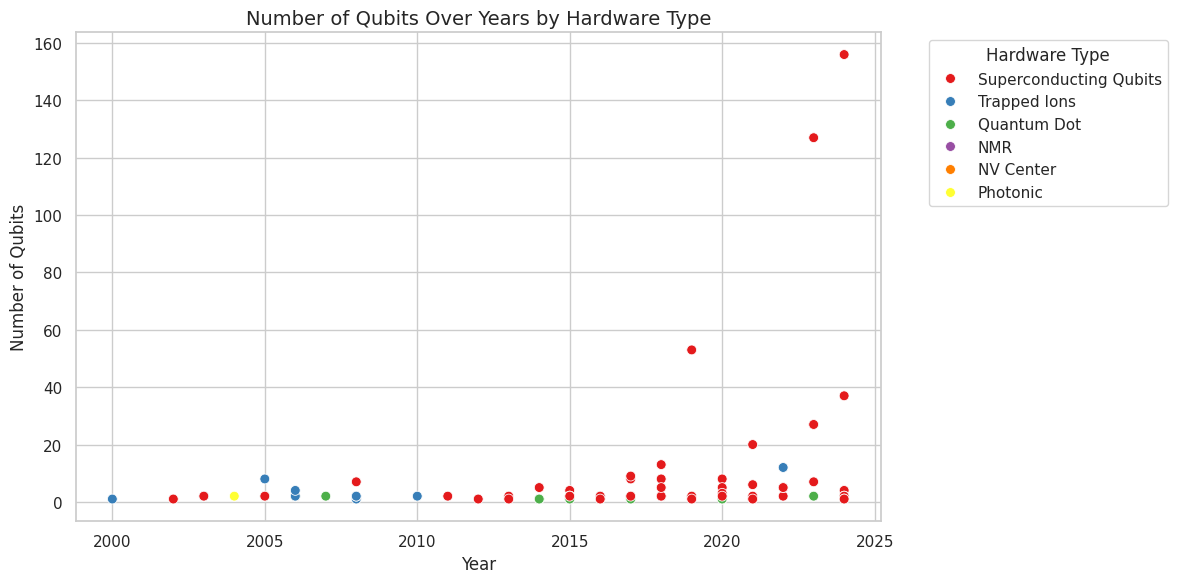

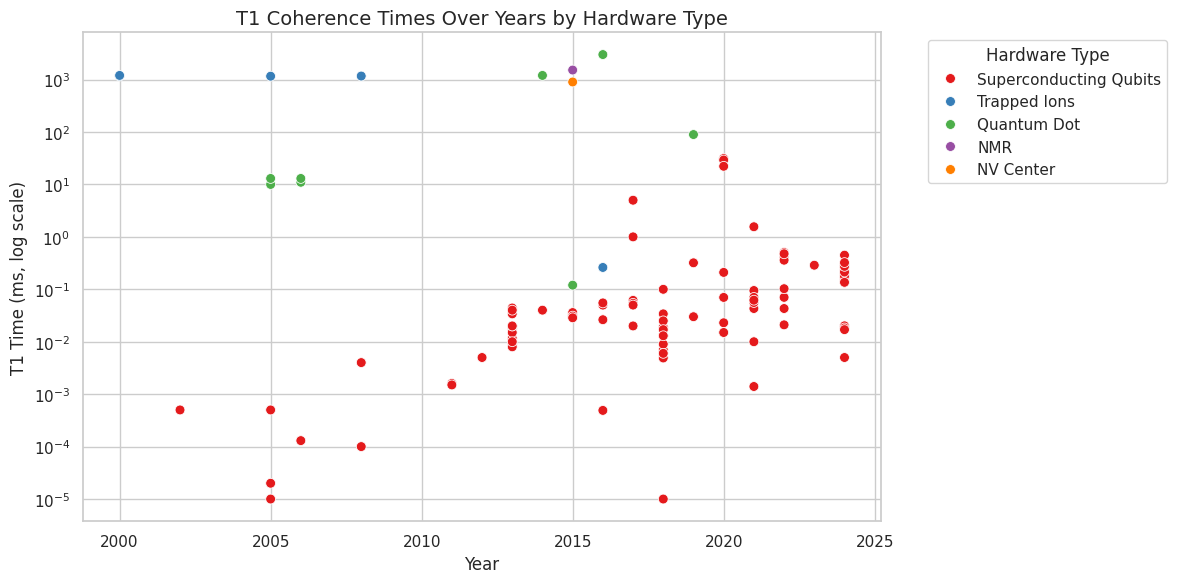

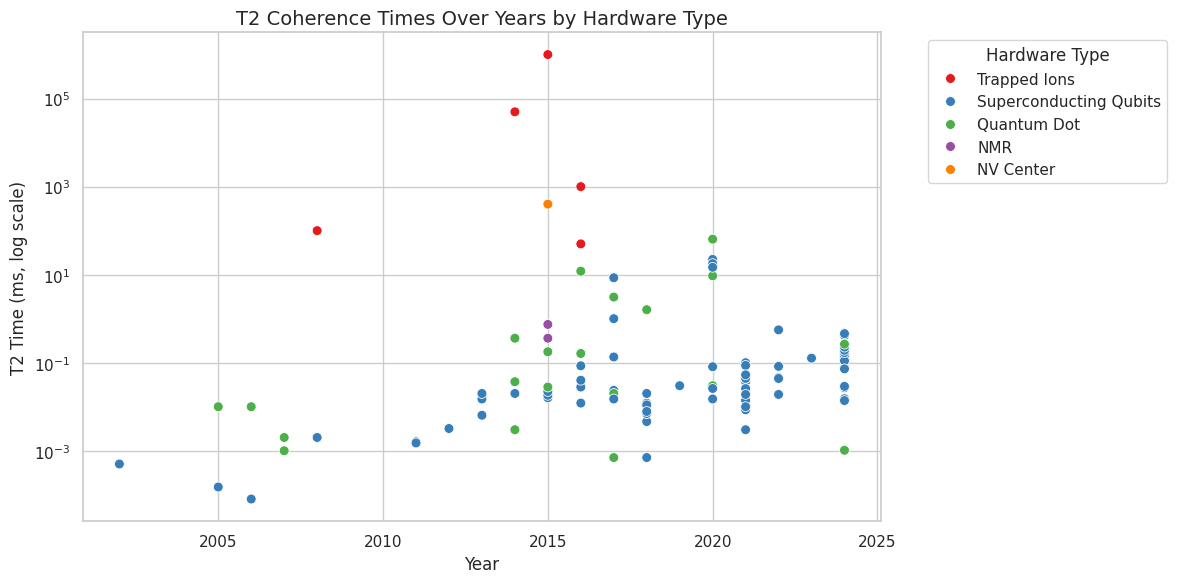

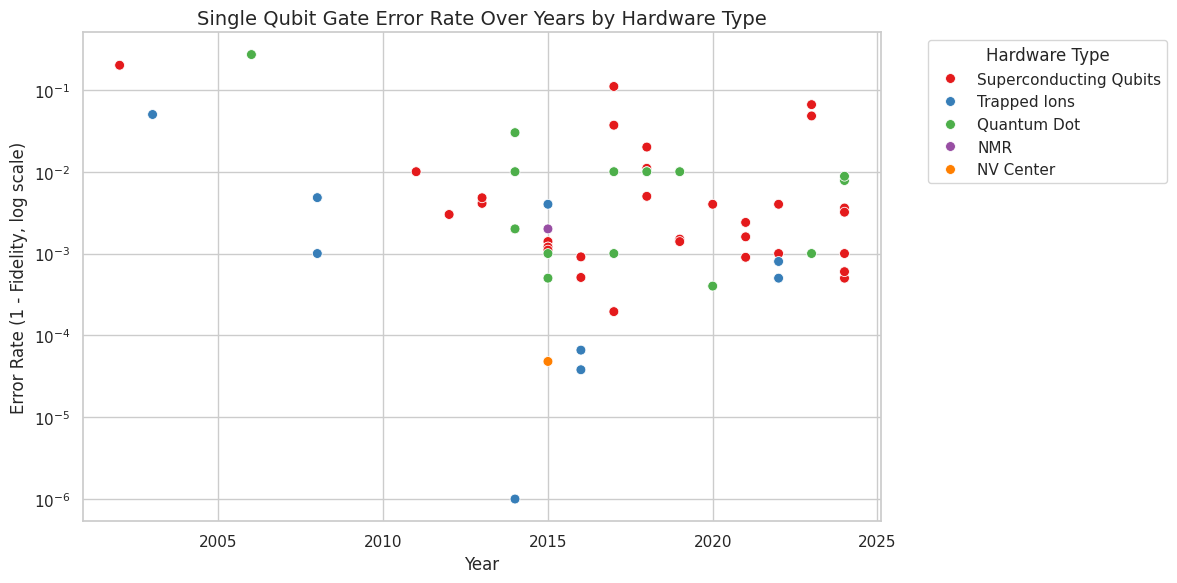

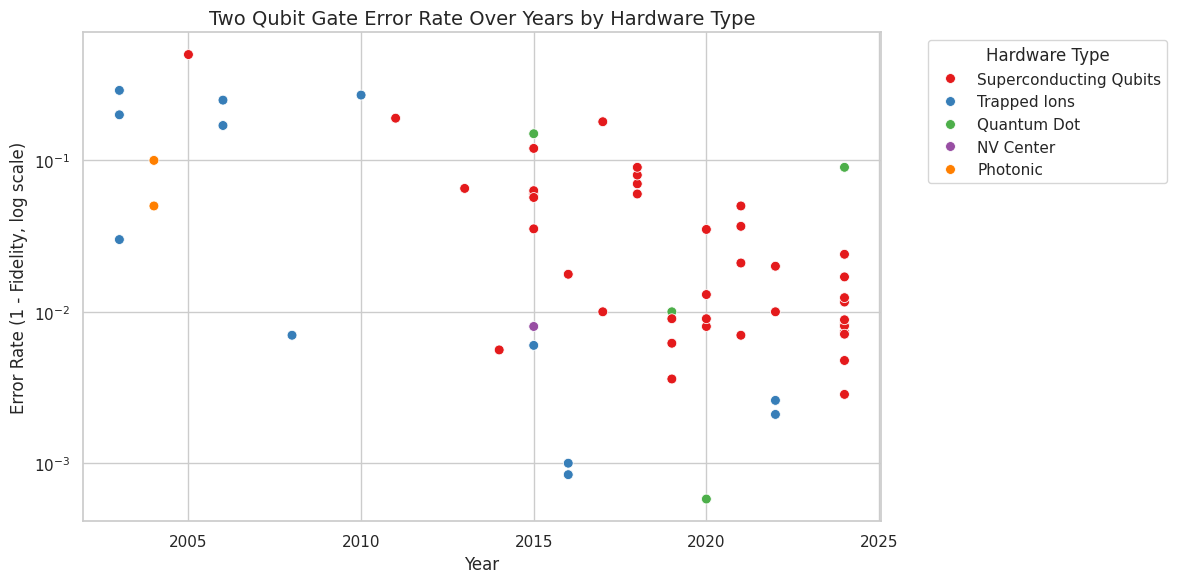

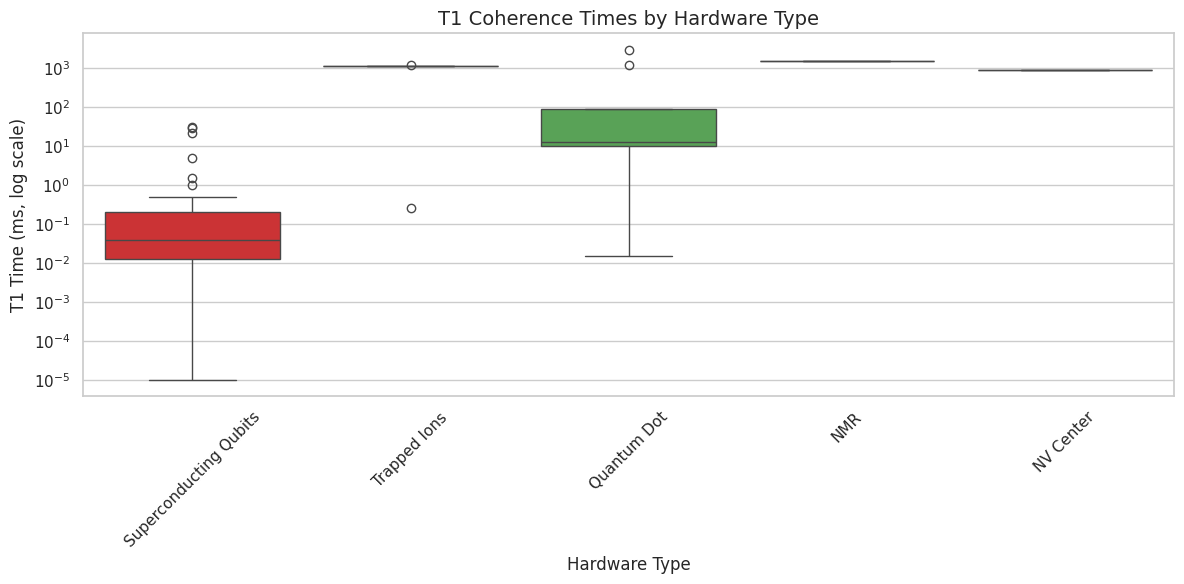

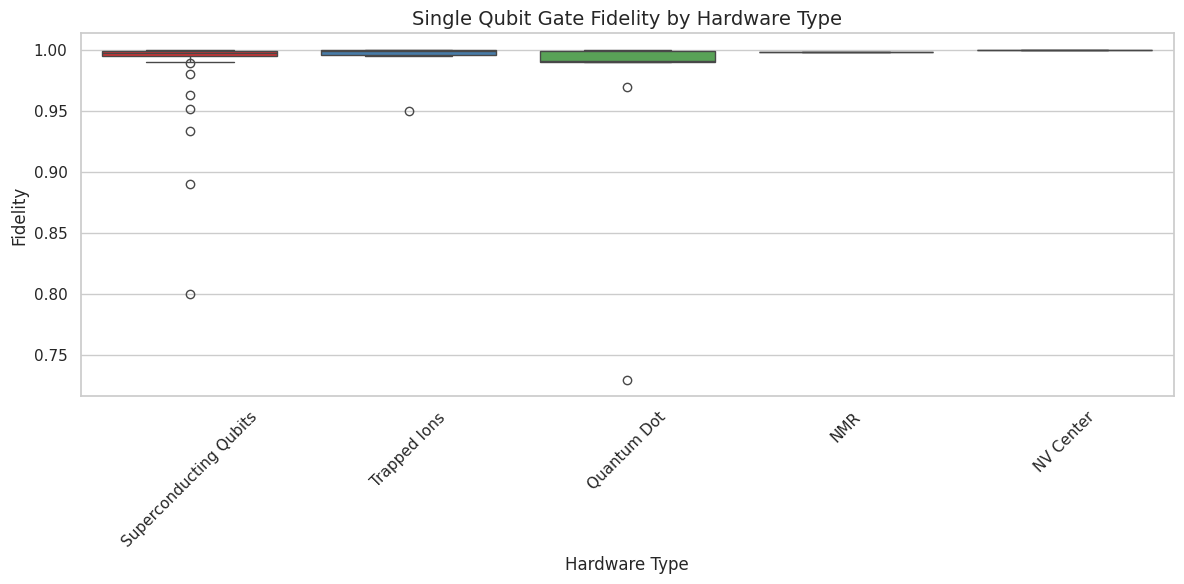

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

conn = sqlite3.connect('qubit_data.db')

# Function to retrieve and merge data
def get_merged_data(table_name):
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    merged = pd.merge(df, main_df[['DOI', 'Year', 'Hardware_Type']], on='DOI')
    merged['Year'] = pd.to_numeric(merged['Year'], errors='coerce').astype('Int64')  # Ensure integer years
    merged['Value'] = pd.to_numeric(merged['Value'], errors='coerce')
    merged = merged.dropna(subset=['Year', 'Value'])
    return merged

# Retrieve main table data
main_df = pd.read_sql_query("SELECT DOI, Hardware_Type, Year, Number_of_Qubits FROM main", conn)
main_df['Number_of_Qubits'] = pd.to_numeric(main_df['Number_of_Qubits'], errors='coerce')
main_df['Year'] = pd.to_numeric(main_df['Year'], errors='coerce').astype('Int64')  # Ensure integer years
main_df = main_df.dropna(subset=['Number_of_Qubits', 'Year'])

# 1. Number of Qubits vs. Year
plt.figure(figsize=(12, 6))
sns.scatterplot(data=main_df, x='Year', y='Number_of_Qubits', hue='Hardware_Type', s=50, alpha=1.0, palette='Set1')
# plt.yscale('log')
plt.title('Number of Qubits Over Years by Hardware Type', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Qubits', fontsize=12)
plt.legend(title='Hardware Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. T1 Times vs. Year
t1_merged = get_merged_data('T1_Times')
plt.figure(figsize=(12, 6))
sns.scatterplot(data=t1_merged, x='Year', y='Value', hue='Hardware_Type', s=50, alpha=1.0, palette='Set1')
plt.yscale('log')
plt.title('T1 Coherence Times Over Years by Hardware Type', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('T1 Time (ms, log scale)', fontsize=12)
plt.legend(title='Hardware Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. T2 Times vs. Year
t2_merged = get_merged_data('T2_Times')
plt.figure(figsize=(12, 6))
sns.scatterplot(data=t2_merged, x='Year', y='Value', hue='Hardware_Type', s=50, alpha=1.0, palette='Set1')
plt.yscale('log')
plt.title('T2 Coherence Times Over Years by Hardware Type', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('T2 Time (ms, log scale)', fontsize=12)
plt.legend(title='Hardware Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Single Qubit Gate Error Rate vs. Year
sqf_merged = get_merged_data('Single_Qubit_Fidelity')
sqf_merged['Error_Rate'] = 1 - sqf_merged['Value']
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sqf_merged, x='Year', y='Error_Rate', hue='Hardware_Type', s=50, alpha=1.0, palette='Set1')
plt.yscale('log')
plt.title('Single Qubit Gate Error Rate Over Years by Hardware Type', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Error Rate (1 - Fidelity, log scale)', fontsize=12)
plt.legend(title='Hardware Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Two Qubit Gate Error Rate vs. Year
tqf_merged = get_merged_data('Two_Qubit_Fidelity')
tqf_merged['Error_Rate'] = 1 - tqf_merged['Value']
plt.figure(figsize=(12, 6))
sns.scatterplot(data=tqf_merged, x='Year', y='Error_Rate', hue='Hardware_Type', s=50, alpha=1.0, palette='Set1')
plt.yscale('log')
plt.title('Two Qubit Gate Error Rate Over Years by Hardware Type', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Error Rate (1 - Fidelity, log scale)', fontsize=12)
plt.legend(title='Hardware Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Box Plot of T1 Times by Hardware Type
plt.figure(figsize=(12, 6))
sns.boxplot(data=t1_merged, x='Hardware_Type', y='Value', hue='Hardware_Type', palette='Set1', legend=False)
plt.yscale('log')
plt.title('T1 Coherence Times by Hardware Type', fontsize=14)
plt.xlabel('Hardware Type', fontsize=12)
plt.ylabel('T1 Time (ms, log scale)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Box Plot of Single Qubit Gate Fidelity by Hardware Type
sqf_merged['Error_Rate'] = 1+sqf_merged['Value']
plt.figure(figsize=(12, 6))
sns.boxplot(data=sqf_merged, x='Hardware_Type', y='Value', hue='Hardware_Type', palette='Set1', legend=False)
plt.title('Single Qubit Gate Fidelity by Hardware Type', fontsize=14)
plt.xlabel('Hardware Type', fontsize=12)
plt.ylabel('Fidelity', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

conn.close()

## More plots

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Connect to the database
conn = sqlite3.connect('qubit_data.db')

# Function to load data from a specific table with main table information
def load_table_data(table_name):
    query = f"""
    SELECT m.DOI, m.Hardware_Type, m.Year, m.Number_of_Qubits, m.Temperature_K,
           t.Value, t.Uncertainty
    FROM {table_name} t
    JOIN main m ON t.DOI = m.DOI
    WHERE t.Value IS NOT NULL
    """
    return pd.read_sql_query(query, conn)

# Set the style for our plots
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

### Gate Fidelities over Time (Line Plot)

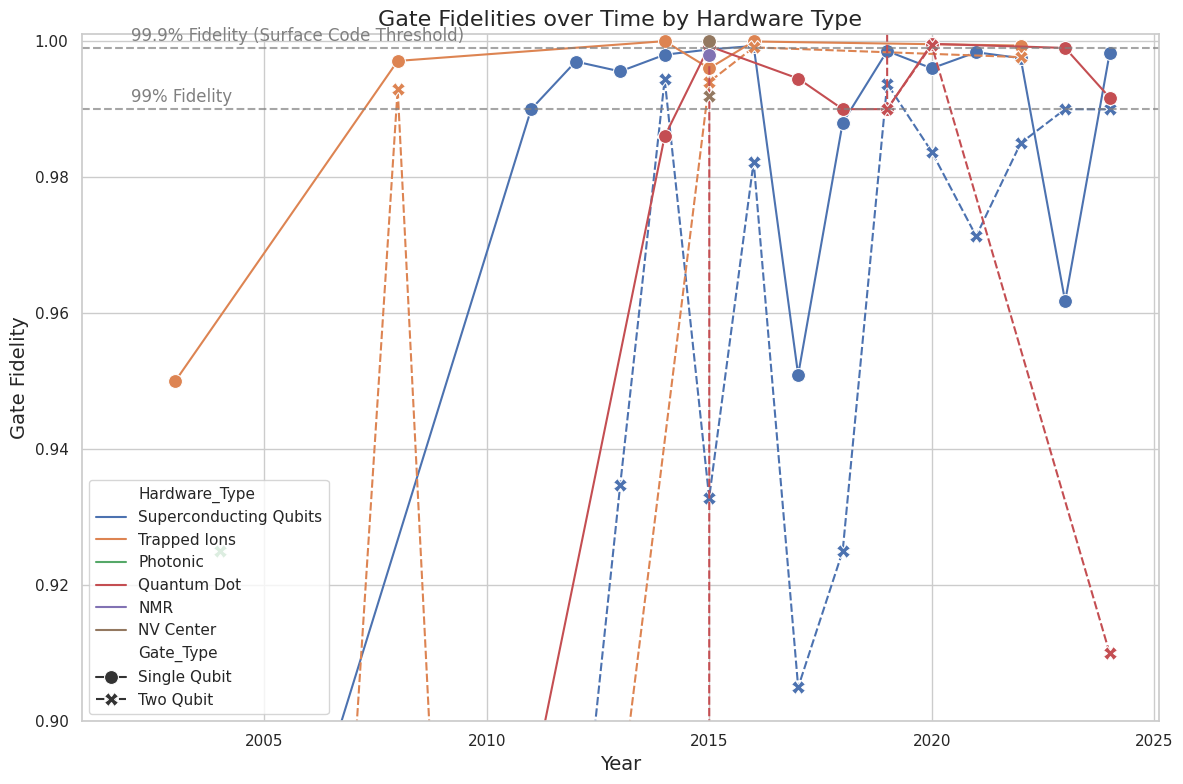

In [11]:
# Load both single and two qubit fidelity data
df_1q = load_table_data('Single_Qubit_Fidelity')
df_1q['Gate_Type'] = 'Single Qubit'
df_2q = load_table_data('Two_Qubit_Fidelity')
df_2q['Gate_Type'] = 'Two Qubit'

# Combine the data
df_fidelity = pd.concat([df_1q, df_2q])
df_fidelity['Year'] = pd.to_numeric(df_fidelity['Year'], errors='coerce')
df_fidelity = df_fidelity.dropna(subset=['Year', 'Value'])

# Calculate mean fidelity per year and gate type
fidelity_by_year = df_fidelity.groupby(['Year', 'Gate_Type', 'Hardware_Type'])['Value'].mean().reset_index()

plt.figure(figsize=(12, 8))
line = sns.lineplot(
    data=fidelity_by_year,
    x='Year',
    y='Value',
    hue='Hardware_Type',
    style='Gate_Type',
    markers=True,
    dashes=True,
    markersize=10
)

# Add horizontal lines for important thresholds
plt.axhline(y=0.99, color='gray', linestyle='--', alpha=0.7)
plt.text(fidelity_by_year['Year'].min(), 0.991, '99% Fidelity', color='gray')

plt.axhline(y=0.999, color='gray', linestyle='--', alpha=0.7)
plt.text(fidelity_by_year['Year'].min(), 1.0, '99.9% Fidelity (Surface Code Threshold)', color='gray')

plt.title('Gate Fidelities over Time by Hardware Type', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Gate Fidelity', fontsize=14)
plt.ylim(0.9, 1.001)  # Set y-axis limits to focus on high fidelities
plt.tight_layout()
plt.show()  # Display the plot in Colab

### Error Rates Comparison (Bar Plot)

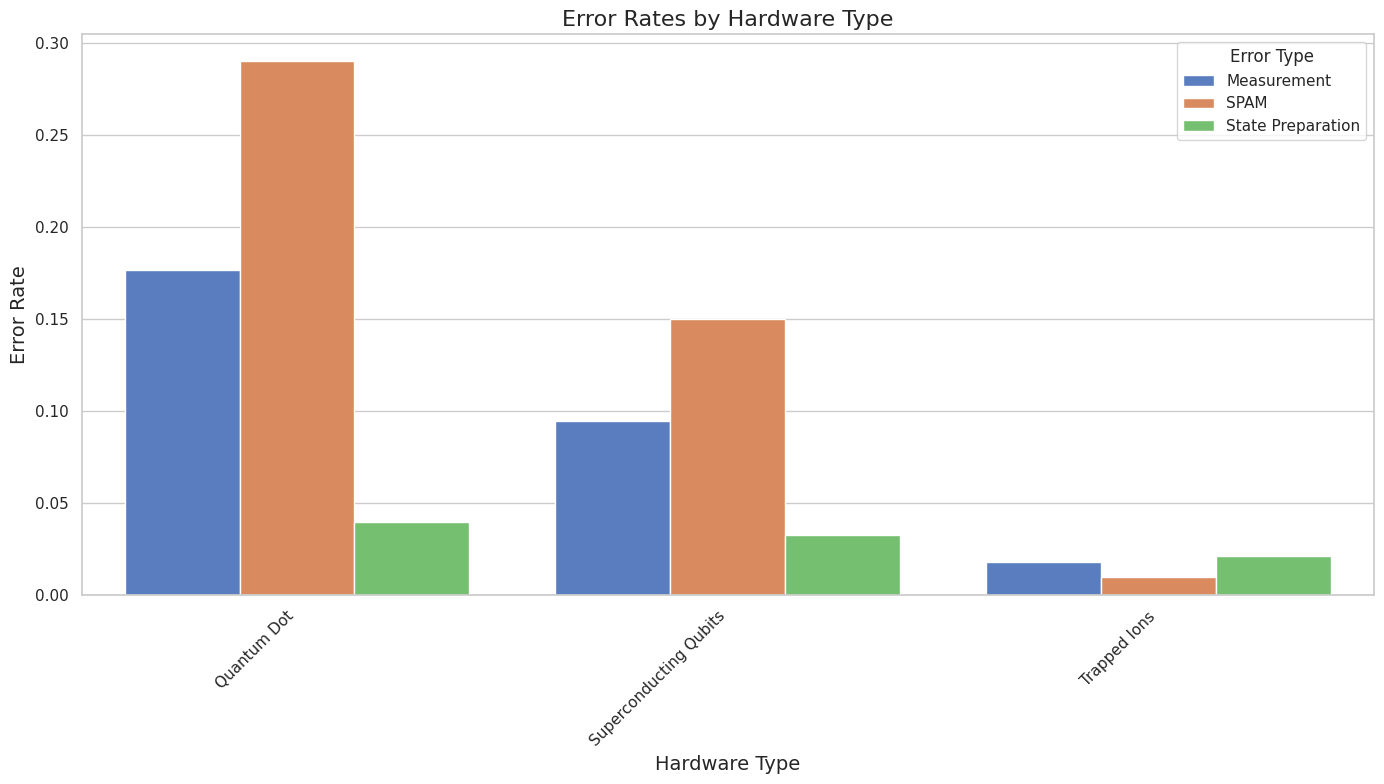

In [12]:
# Load different error types
df_meas = load_table_data('Measurement_Error')
df_meas['Error_Type'] = 'Measurement'

df_prep = load_table_data('State_Prep_Error')
df_prep['Error_Type'] = 'State Preparation'

df_spam = load_table_data('SPAM_Error')
df_spam['Error_Type'] = 'SPAM'

# Combine the data
df_errors = pd.concat([df_meas, df_prep, df_spam])

# Calculate mean error rates by hardware type and error type
error_by_hw = df_errors.groupby(['Hardware_Type', 'Error_Type'])['Value'].mean().reset_index()

plt.figure(figsize=(14, 8))
bars = sns.barplot(
    data=error_by_hw,
    x='Hardware_Type',
    y='Value',
    hue='Error_Type',
    palette='muted'
)

plt.title('Error Rates by Hardware Type', fontsize=16)
plt.xlabel('Hardware Type', fontsize=14)
plt.ylabel('Error Rate', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Error Type')
plt.tight_layout()
plt.show()

### Gate time vs Temperature

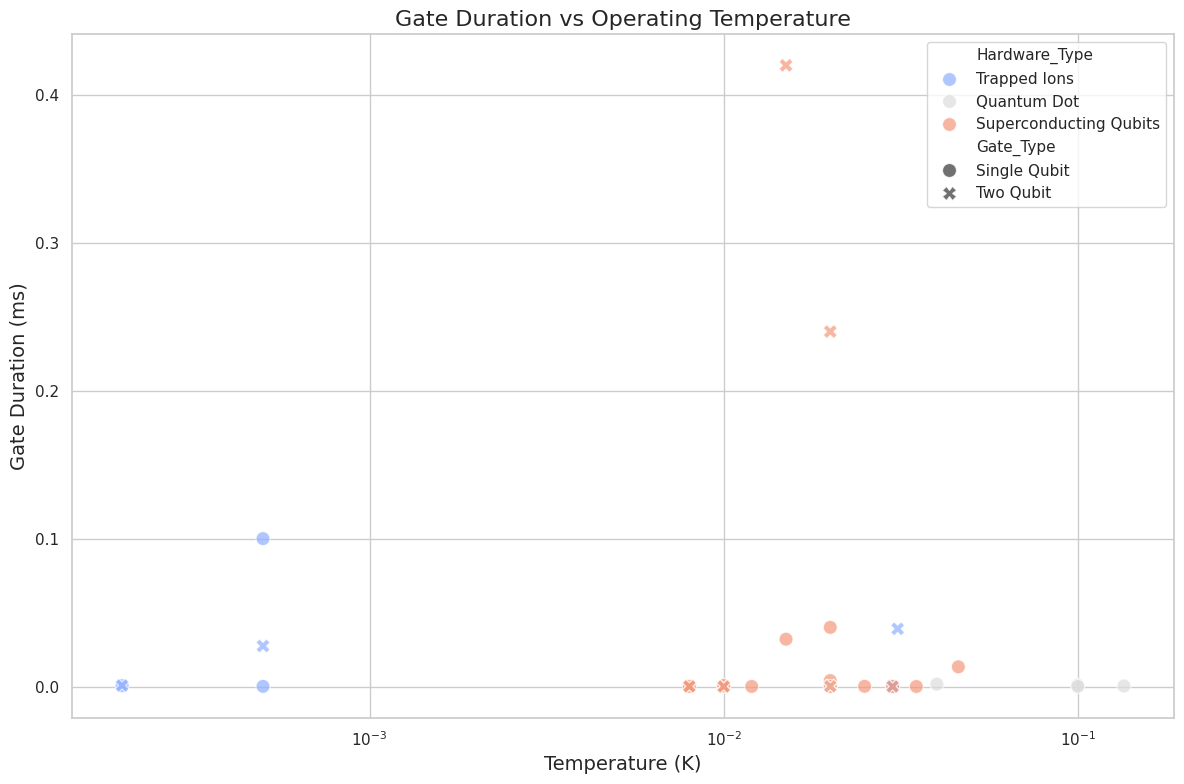

In [13]:
# Load gate durations
df_1q_time = load_table_data('Single_Qubit_Gate_time')
df_1q_time['Gate_Type'] = 'Single Qubit'
df_2q_time = load_table_data('Two_Qubit_Gate_time')
df_2q_time['Gate_Type'] = 'Two Qubit'

# Combine the data
df_times = pd.concat([df_1q_time, df_2q_time])
df_times['Temperature_K'] = pd.to_numeric(df_times['Temperature_K'], errors='coerce')
df_times = df_times.dropna(subset=['Temperature_K', 'Value'])

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df_times,
    x='Temperature_K',
    y='Value',
    hue='Hardware_Type',
    style='Gate_Type',
    palette='coolwarm',
    s=100,
    alpha=0.7
)

plt.title('Gate Duration vs Operating Temperature', fontsize=16)
plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('Gate Duration (ms)', fontsize=14)
plt.xscale('log')  # Log scale for temperature to better visualize cryogenic range
plt.tight_layout()
plt.show()

### Number of Qubits vs Year

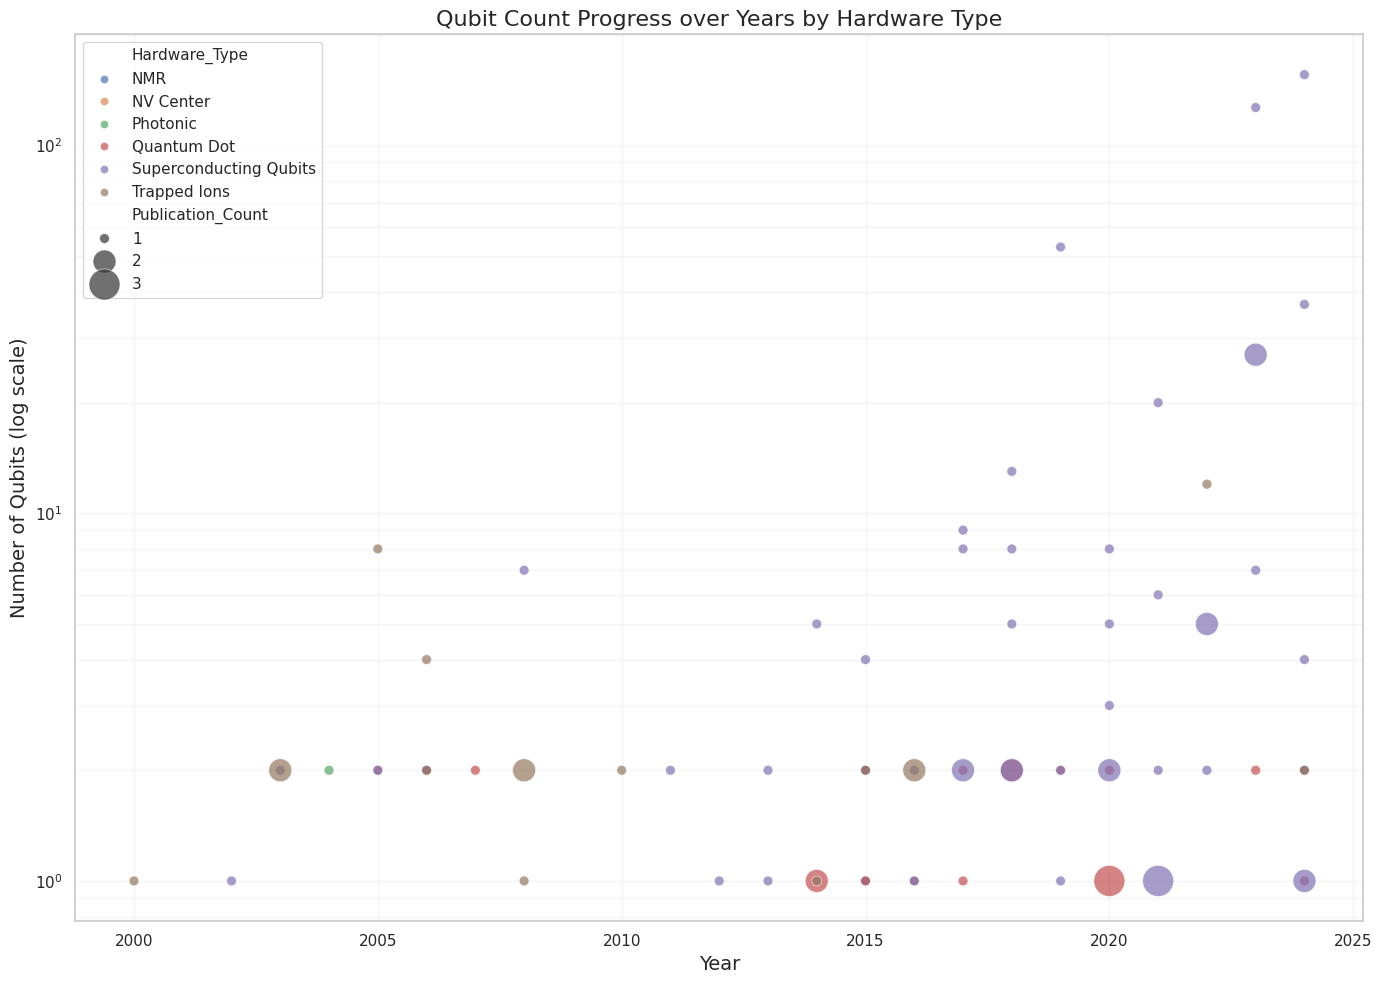

In [14]:
# Query the main table for qubit counts by year and hardware type
query = """
SELECT Hardware_Type, Year, Number_of_Qubits, COUNT(DOI) as Publication_Count
FROM main
WHERE Year != '-' AND Number_of_Qubits != '-'
GROUP BY Hardware_Type, Year, Number_of_Qubits
"""
df_qubits = pd.read_sql_query(query, conn)
df_qubits['Year'] = pd.to_numeric(df_qubits['Year'], errors='coerce')
df_qubits['Number_of_Qubits'] = pd.to_numeric(df_qubits['Number_of_Qubits'], errors='coerce')
df_qubits = df_qubits.dropna(subset=['Year', 'Number_of_Qubits'])

plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df_qubits,
    x='Year',
    y='Number_of_Qubits',
    hue='Hardware_Type',
    size='Publication_Count',
    sizes=(50, 500),
    alpha=0.7
)

plt.title('Qubit Count Progress over Years by Hardware Type', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Qubits (log scale)', fontsize=14)
plt.yscale('log')  # Log scale for qubit count to visualize growth
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

### Heatmap of Average Performance Metrics by Hardware Type

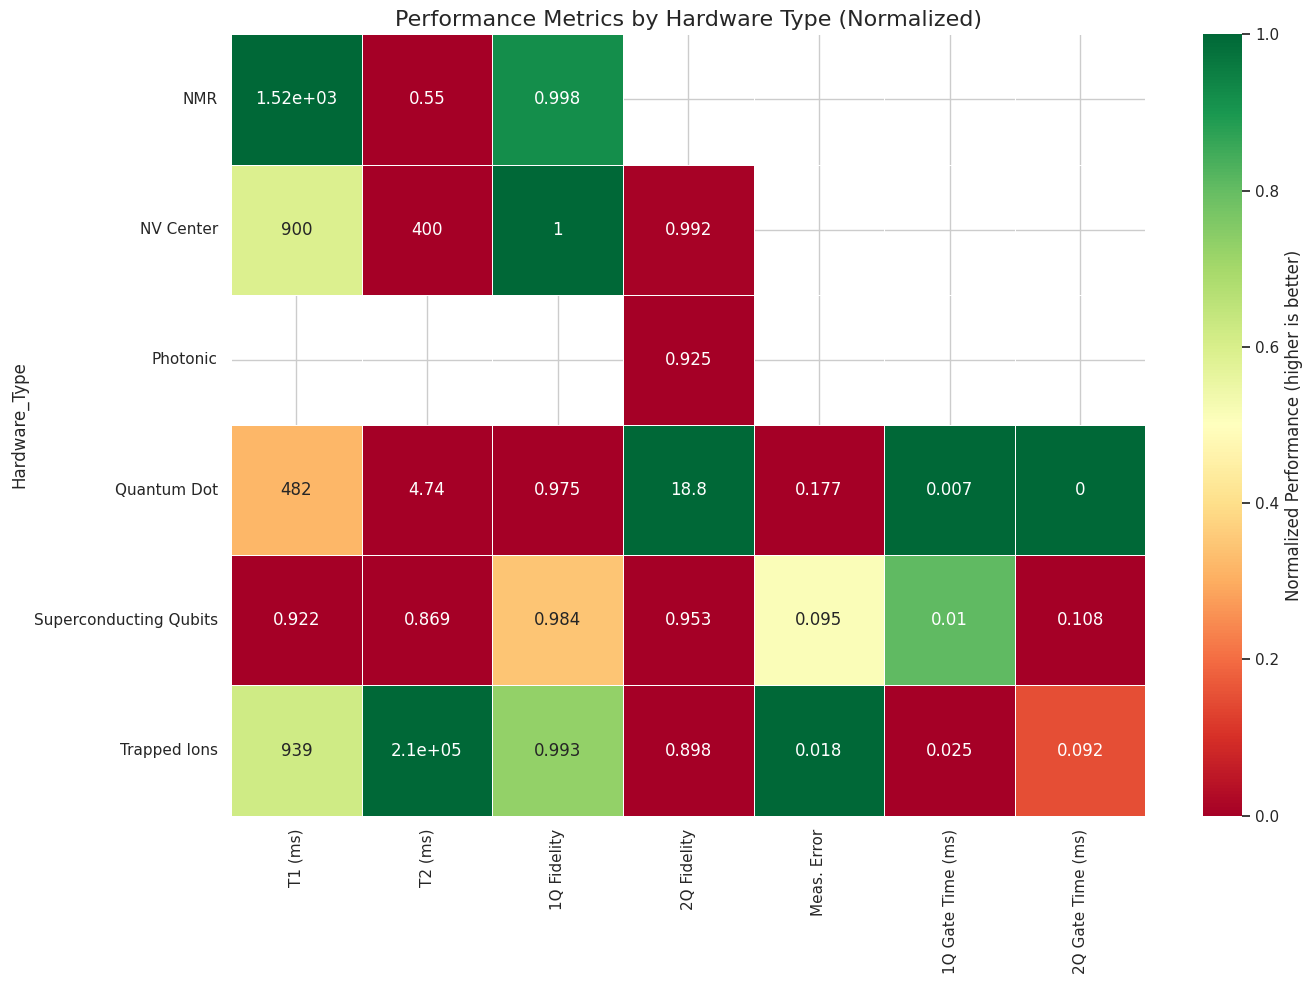

In [16]:
# Create a function to get average values for each metric by hardware type
def get_metric_avg(table_name):
    query = f"""
    SELECT m.Hardware_Type, AVG(t.Value) as Avg_Value
    FROM {table_name} t
    JOIN main m ON t.DOI = m.DOI
    GROUP BY m.Hardware_Type
    """
    return pd.read_sql_query(query, conn)

# Get metrics for different tables
metrics = {
    'T1 (ms)': get_metric_avg('T1_Times'),
    'T2 (ms)': get_metric_avg('T2_Times'),
    '1Q Fidelity': get_metric_avg('Single_Qubit_Fidelity'),
    '2Q Fidelity': get_metric_avg('Two_Qubit_Fidelity'),
    'Meas. Error': get_metric_avg('Measurement_Error'),
    '1Q Gate Time (ms)': get_metric_avg('Single_Qubit_Gate_time'),
    '2Q Gate Time (ms)': get_metric_avg('Two_Qubit_Gate_time')
}

# Combine all metrics into a single dataframe
dfs = []
for metric_name, df in metrics.items():
    if not df.empty:
        df = df.rename(columns={'Avg_Value': metric_name})
        dfs.append(df)

if dfs:
    # Merge all dataframes on Hardware_Type
    df_combined = dfs[0]
    for df in dfs[1:]:
        df_combined = pd.merge(df_combined, df, on='Hardware_Type', how='outer')

    # Pivot the dataframe for the heatmap
    df_pivot = df_combined.set_index('Hardware_Type')

    plt.figure(figsize=(14, 10))
    mask = np.isnan(df_pivot)

    # Normalize each column to make them comparable
    df_norm = df_pivot.copy()
    for col in df_norm.columns:
        if 'Fidelity' in col:
            # For fidelity, higher is better
            df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
        elif 'Error' in col:
            # For errors, lower is better, so invert the normalization
            df_norm[col] = 1 - (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
        elif 'Gate Time' in col:
            # For gate times, lower is better, so invert the normalization
            df_norm[col] = 1 - (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
        else:
            # For coherence times, higher is better
            df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())

    # Create the heatmap
    heatmap = sns.heatmap(
        df_norm,
        annot=df_pivot.round(3),  # Show original values in annotations
        fmt='.3g',
        cmap='RdYlGn',
        mask=mask,
        linewidths=0.5,
        cbar_kws={'label': 'Normalized Performance (higher is better)'}
    )

    plt.title('Performance Metrics by Hardware Type (Normalized)', fontsize=16)
    plt.tight_layout()
    plt.show()

### Plot to see specific data points

In [17]:
# Install Plotly if needed
# !pip install plotly -q

import plotly.express as px
import plotly.io as pio

# Get T1 data with years
df_t1_years = load_table_data('T1_Times')
df_t1_years['Year'] = pd.to_numeric(df_t1_years['Year'], errors='coerce')
# Make sure Number_of_Qubits is numeric
df_t1_years['Number_of_Qubits'] = pd.to_numeric(df_t1_years['Number_of_Qubits'], errors='coerce')
df_t1_years = df_t1_years.dropna(subset=['Year', 'Value'])

# Set a default size for missing qubit counts
df_t1_years['Number_of_Qubits'] = df_t1_years['Number_of_Qubits'].fillna(1)

# Create the interactive plot
fig = px.scatter(
    df_t1_years,
    x='Year',
    y='Value',
    color='Hardware_Type',
    size='Number_of_Qubits',  # Now numeric
    size_max=25,  # Adjust the maximum size
    hover_name='DOI',
    title='T1 Coherence Time Evolution (Interactive)',
    labels={'Value': 'T1 Time (ms)', 'Year': 'Year'},
    height=800
)

# Add trendlines
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))

fig.show()

In [18]:
conn.close()